<a href="https://colab.research.google.com/github/chad-fisher/CRWA-Regional-Tree-Planting-and-Protection-Plan/blob/main/CodeNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

In [2]:
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as cx
import ee
import geemap
import geemap.foliumap as geemapf
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import wget
import zipfile
import datetime
import pyinaturalist
from scipy import ndimage
import urllib
import rasterstats
import glob 

In [8]:
#Authenticate to Earth Engine
ee.Authenticate()

<IPython.core.display.HTML object>

True

In [9]:
#Initialize earth engine project
ee.Initialize(project='ee-cefisher20')

<IPython.core.display.HTML object>

In [5]:
cd "C:\Users\Chad\Desktop\CRWA Project\CRWA-Regional-Tree-Planting-and-Protection-Plan\CRWA-Regional-Tree-Planting-and-Protection-Plan"

<IPython.core.display.HTML object>

C:\Users\Chad\Desktop\CRWA Project\CRWA-Regional-Tree-Planting-and-Protection-Plan\CRWA-Regional-Tree-Planting-and-Protection-Plan


# Downloading data

In [ ]:
#UMASS CAPS data
!python -m wget -o "C:/Users/Chad/Desktop/CRWA Project/Raw_Data" "https://landeco.umass.edu/web/masscaps/standard.zip"
zipfile.ZipFile('C:/Users/Chad/Desktop/CRWA Project/Raw_Data/standard.zip').extractall(path='C:/Users/Chad/Desktop/CRWA Project/Raw_Data/standard/')

In [ ]:
#MASSGIS SSURGO data
!python -m wget -o "C:/Users/Chad/Desktop/CRWA Project/Raw_Data" "https://s3.us-east-1.amazonaws.com/download.massgis.digital.mass.gov/shapefiles/state/Soils_MassGIS_SHP.zip"
zipfile.ZipFile("C:/Users/Chad/Desktop/CRWA Project/Raw_Data/Soils_MassGIS_SHP.zip").extractall(path="C:/Users/Chad/Desktop/CRWA Project/Raw_Data/Soils_MassGIS_SHP/")

In [ ]:
#MASSGIS Watershed data
!python -m wget -o "C:/Users/Chad/Desktop/CRWA Project/Raw_Data" "https://s3.us-east-1.amazonaws.com/download.massgis.digital.mass.gov/shapefiles/state/watshd.zip"
zipfile.ZipFile("C:/Users/Chad/Desktop/CRWA Project/Raw_Data/watshd.zip").extractall(path="C:/Users/Chad/Desktop/CRWA Project/Raw_Data/watshd/")

In [ ]:
#MASSGIS Municipalities Data
!python -m wget -o "C:/Users/Chad/Desktop/CRWA Project/Raw_Data" "https://s3.us-east-1.amazonaws.com/download.massgis.digital.mass.gov/shapefiles/census2020/CENSUS2020TOWNS_SHP.zip"
zipfile.ZipFile("C:/Users/Chad/Desktop/CRWA Project/Raw_Data/CENSUS2020TOWNS_SHP.zip").extractall(path="C:/Users/Chad/Desktop/CRWA Project/Raw_Data/CENSUS2020TOWNS_SHP/")

In [ ]:
#Analyze Boston NBHDS data
!python -m wget -o "C:/Users/Chad/Desktop/CRWA Project/Raw_Data" "https://bostonopendata-boston.opendata.arcgis.com/api/download/v1/items/6505e8fc489b48cc848abeccc6e87b79/shapefile?layers=0"
zipfile.ZipFile(r"C:\Users\Chad\Desktop\CRWA Project\Raw_Data\Boston_Neighborhood_Boundaries_Approximated_by_2020_Census_Block_Groups.zip").extractall(path="C:/Users/Chad/Desktop/CRWA Project/Raw_Data/Boston NBHDS/")

# Miscellaneous tools

In [96]:
#Extracting hex codes from matplotlib color maps
colors = mpl.colormaps['BrBG'].resampled(7)
for i in range(0,7):
    print(mpl.colors.to_hex(colors(i)))

<IPython.core.display.HTML object>

#543005
#ae7121
#e7cf94
#f5f5f5
#98d7cd
#24877f
#003c30


# Extracting watershed boundaries

In [10]:
#HUC codes from https://apps.nationalmap.gov/viewer/
Charles=ee.FeatureCollection("USGS/WBD/2017/HUC10").filter("huc10 == '0109000107' or huc10 == '0109000106'")
Charles_lower=ee.FeatureCollection("USGS/WBD/2017/HUC10").filter("huc10 == '0109000107'")
Charles_upper=ee.FeatureCollection("USGS/WBD/2017/HUC10").filter("huc10 == '0109000106'")

<IPython.core.display.HTML object>

In [11]:
#Convert earth engine feature collections to geopandas data frames
Charles_gdf = ee.data.computeFeatures({
    'expression': Charles,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
Charles_gdf.crs = 'EPSG:4326'

Charles_lower_gdf = ee.data.computeFeatures({
    'expression': Charles_lower,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
Charles_lower_gdf.crs = 'EPSG:4326'

Charles_upper_gdf = ee.data.computeFeatures({
    'expression': Charles_upper,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
Charles_upper_gdf.crs = 'EPSG:4326'

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

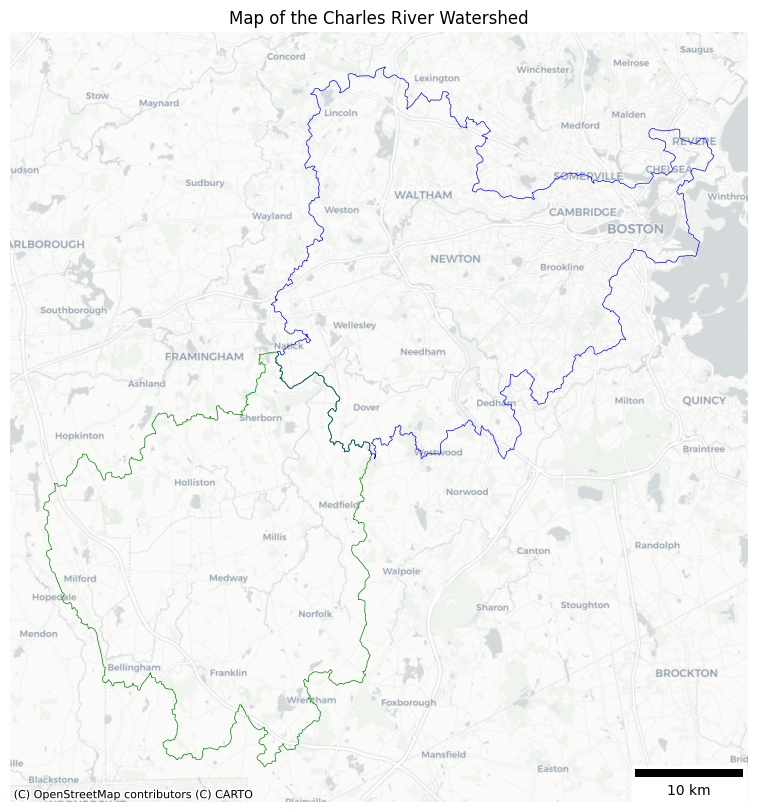

In [7]:
ax = Charles_lower_gdf.to_crs(epsg=3857).boundary.plot(figsize=(10,10), color='blue',linewidth=0.5)
Charles_upper_gdf.to_crs(epsg=3857).boundary.plot(ax=ax,figsize=(10,10), color='green',linewidth=0.5)
plt.title("Map of the Charles River Watershed")
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.add_artist(ScaleBar(1,location='lower right'))
plt.savefig("Charles River Watershed Overview Map.png")

# Forest Cover Maps

In [84]:
# Calculate and extract raster of tree cover change from 2005 to 2020 from GEE
treeCover2005=ee.Image('MODIS/006/MOD44B/2005_03_06').clip(Charles).select('Percent_Tree_Cover').reproject(crs='EPSG:3857',scale=250)
treeCover2020=ee.Image('MODIS/006/MOD44B/2020_03_05').clip(Charles).select('Percent_Tree_Cover').reproject(crs='EPSG:3857',scale=250)
dtreeCover=treeCover2020.subtract(treeCover2005)
dtreeCover=geemap.ee_export_image(dtreeCover, filename='../../Working_Data/dtreeCover.tif', region=Charles.geometry(), file_per_band=False)

<IPython.core.display.HTML object>

In [89]:
# Mask tree cover change to watershed and obtain its plotting extent to use later for lining up vector data
dtreeCover,trans=mask(rio.open('../../Working_Data/dtreeCover.tif'),Charles_gdf.to_crs(epsg=3857).geometry,crop=True)
plot_extent = rio.plot.plotting_extent(rio.open('../../Working_Data/dtreeCover.tif'))

<IPython.core.display.HTML object>

In [28]:
# Read in towns SHP and clip/dissolve polygons 
towns=gpd.read_file("../../Raw_Data/CENSUS2020TOWNS_SHP/CENSUS2020TOWNS_POLY.shp").to_crs(Charles_gdf.crs).clip(Charles_gdf)
Charles_Towns=towns.to_crs(epsg=3857).dissolve('NAMELSAD20')

<IPython.core.display.HTML object>

In [29]:
# List of names of towns participating in the climate compact from https://www.crwa.org/climate-compact
CC_Towns=['Arlington', 'Bellingham', 'Belmont', 'Boston', 'Brookline', 'Cambridge', 'Dedham', 'Dover', 'Franklin', 'Holliston', 'Hopkinton', 'Lincoln', 'Medfield', 'Medway', 'Millis', 'Natick', 'Needham', 'Newton', 'Norfolk', 'Sherborn', 'Somerville', 'Walpole', 'Waltham', 'Watertown', 'Wellesley', 'Weston', 'Westwood', 'Wrentham']

<IPython.core.display.HTML object>

In [67]:
# Calculate zonal statistics, join back onto town data frame and extract town name
townStats=pd.DataFrame(rasterstats.zonal_stats(Charles_Towns, "../../Working_Data/dtreeCover.tif",stats="count min mean max median"),index=Charles_Towns.index)
townStats=townStats.merge(Charles_Towns.to_crs(epsg=3857),left_index=True,right_index=True)
townStats['name']=townStats.index.str.split(' ').str[0]

<IPython.core.display.HTML object>

In [69]:
# Sort by mean tree canopy percent change
townStats=townStats.sort_values(by='mean')

<IPython.core.display.HTML object>

In [70]:
# Generate coordinates for labeling polygons on maps
townStats['coords'] = townStats['geometry'].apply(lambda x: x.representative_point().coords[:])
townStats['coords'] = [coords[0] for coords in townStats['coords']]

<IPython.core.display.HTML object>

In [71]:
# Extract only Climate Compact towns
townStatsCC=townStats.loc[townStats['name'].isin(CC_Towns)]

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

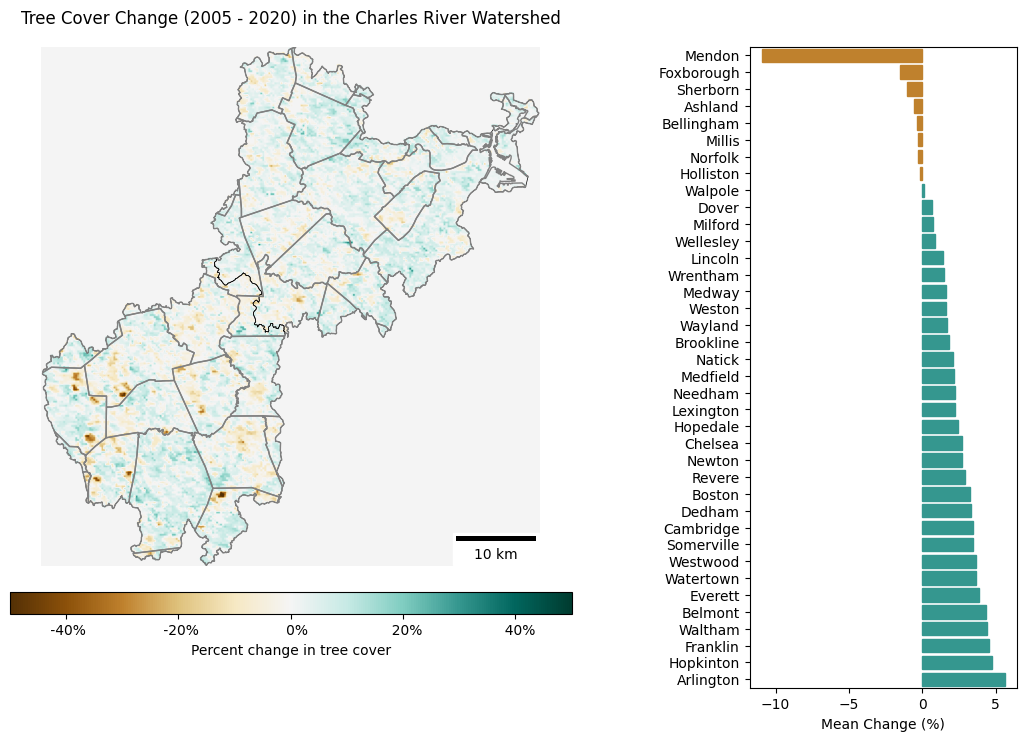

In [104]:
# Plot tree cover change

# Create subplots
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 7),gridspec_kw={'width_ratios': [3, 1]})
f.tight_layout()

# Create hidden version of raster to be used for color bar
hidden = ax[0].imshow(dtreeCover[0,:,:],cmap='BrBG',extent=plot_extent,alpha=1,vmin=-50,vmax=50)

# Add data and layers
show(dtreeCover,cmap='BrBG',ax=ax[0],extent=plot_extent,alpha=1,vmin=-50,vmax=50)
Charles_lower_gdf.to_crs(epsg=3857).boundary.plot(ax=ax[0], color='black',linewidth=0.5)
Charles_upper_gdf.to_crs(epsg=3857).boundary.plot(ax=ax[0], color='black',linewidth=0.5)
towns.to_crs(epsg=3857).boundary.plot(ax=ax[0], color='gray',linewidth=1)

# Add colorbar using hidden version of raster
f.colorbar(hidden, cmap='BrBG',orientation='horizontal',aspect=25,shrink=0.7,pad=.04,label='Percent change in tree cover',format="%4i%%")

# Set properties of plot
ax[0].set(title='Tree Cover Change (2005 - 2020) in the Charles River Watershed')
ax[0].add_artist(ScaleBar(1,location='lower right'))
ax[0].set_axis_off()

# Add barplot, set properties, and change colors
bar_plot=sns.barplot(townStats,ax=ax[1],x='mean',y='name',orient='h',width=0.8)
ax[1].set(ylabel=None,xlabel='Mean Change (%)')
for p in bar_plot.patches:
    if p.get_width() < 0:
        p.set_color('#bf812d')
    else:
        p.set_color('#35978f')

# Save figure 
f.savefig("Output Maps/Tree Cover Change (2005 - 2020) in the Charles River Watershed.png",bbox_inches=mpl.transforms.Bbox.from_bounds(1.2,-0.1,11,7.5))

<IPython.core.display.HTML object>

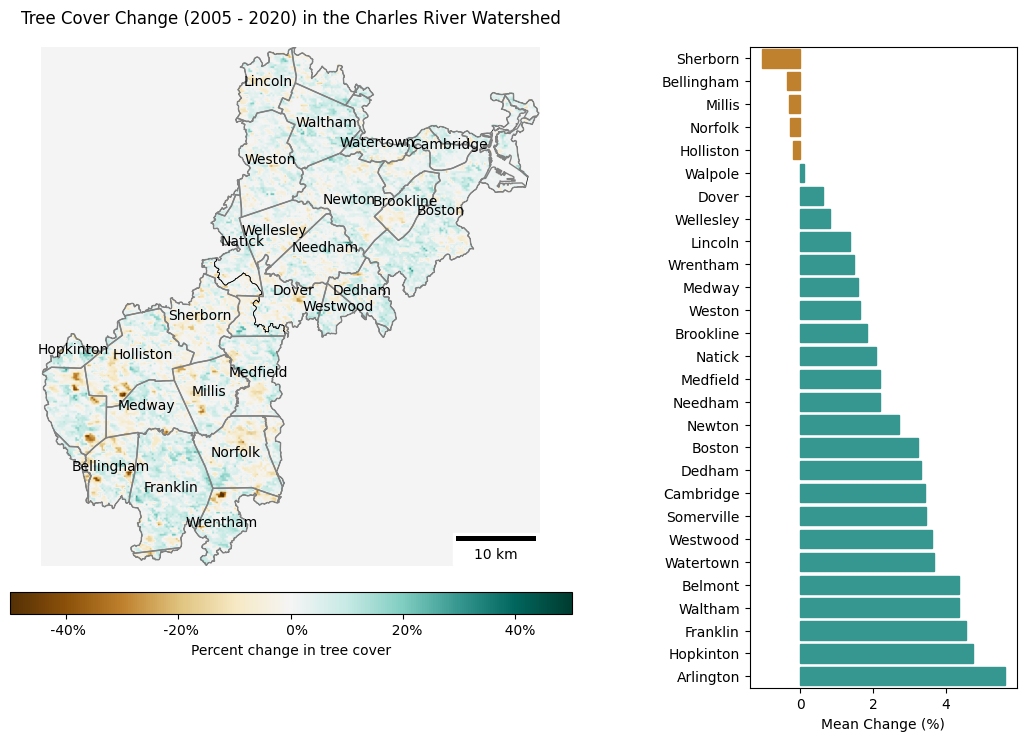

In [105]:
# Plot tree cover change

# Create subplots
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 7),gridspec_kw={'width_ratios': [3, 1]})
f.tight_layout()

# Create hidden version of raster to be used for color bar
hidden = ax[0].imshow(dtreeCover[0,:,:],cmap='BrBG',extent=plot_extent,alpha=1,vmin=-50,vmax=50)

# Add data and layers
show(dtreeCover,cmap='BrBG',ax=ax[0],extent=plot_extent,alpha=1,vmin=-50,vmax=50)
Charles_lower_gdf.to_crs(epsg=3857).boundary.plot(ax=ax[0], color='black',linewidth=0.5)
Charles_upper_gdf.to_crs(epsg=3857).boundary.plot(ax=ax[0], color='black',linewidth=0.5)
towns.to_crs(epsg=3857).boundary.plot(ax=ax[0], color='gray',linewidth=1)

# Label towns
townStatsCC[townStatsCC['count']>200].apply(lambda x: ax[0].annotate(text=x['name'], xy=x['coords'], ha='center'), axis=1)

# Add colorbar using hidden version of raster
f.colorbar(hidden, cmap='BrBG',orientation='horizontal',aspect=25,shrink=0.7,pad=.04,label='Percent change in tree cover',format="%4i%%")

# Set properties of plot
ax[0].set(title='Tree Cover Change (2005 - 2020) in the Charles River Watershed')
ax[0].add_artist(ScaleBar(1,location='lower right'))
ax[0].set_axis_off()

# Add barplot, set properties, and change colors
bar_plot=sns.barplot(townStatsCC,ax=ax[1],x='mean',y='name',orient='h',width=0.8)
ax[1].set(ylabel=None,xlabel='Mean Change (%)')
for p in bar_plot.patches:
    if p.get_width() < 0:
        p.set_color('#bf812d')
    else:
        p.set_color('#35978f')

# Save figure 
f.savefig("Output Maps/Climate Compact Towns Tree Cover Change (2005 - 2020) in the Charles River Watershed.png",bbox_inches=mpl.transforms.Bbox.from_bounds(1.2,-0.1,11,7.5))

# Soils Maps

In [106]:
#Import soils data and clip to boundaries
Ag_soils = gpd.clip(gpd.read_file("../../Raw_Data/Soils_MassGIS_SHP/SOILS_POLY_PRIMEFARMLAND.shp",mask=Charles_gdf.to_crs('EPSG:26986')),Charles_gdf.to_crs('EPSG:26986'))
Soils = gpd.clip(gpd.read_file("../../Raw_Data/Soils_MassGIS_SHP/SOILS_MUPOLYGON_TOP20.shp",mask=Charles_gdf.to_crs('EPSG:26986')),Charles_gdf.to_crs('EPSG:26986'))
Soils.to_file('../../Working_Data/SoilsCRW.shp')  

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

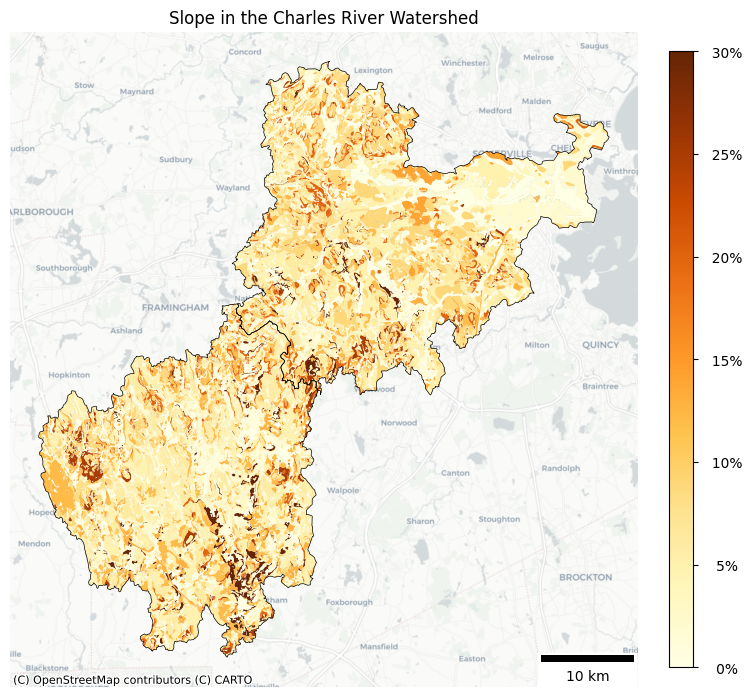

In [108]:
#Slope map
ax=Soils.to_crs(epsg=3857).plot(column='SLOPE_1',cmap='YlOrBr',legend=True,legend_kwds={'format':"%4i%%",'aspect': 25,'shrink': 0.8,'pad': 0.04},figsize=(10,10))
Charles_gdf.to_crs(epsg=3857).boundary.plot(ax=ax, color='black',linewidth=0.5)
plt.title("Slope in the Charles River Watershed")
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.add_artist(ScaleBar(1,location='lower right'))
plt.savefig("Output Maps/SlopeCRW.png")

In [109]:
#(because geopandas doesn't allow you to change sort of a categorical class and defaults to alphabetical,
#I had to recode category)
drain_recode={
    'Excessively drained': 'A',
    'Somewhat excessively drained': 'B',
    'Well drained': 'C',
    'Moderately well drained': 'D',
    'Poorly drained': 'E',
    'Very poorly drained': 'F'
}
Soils['Drain_Code']=Soils['DRAINCLASS'].map(drain_recode)

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

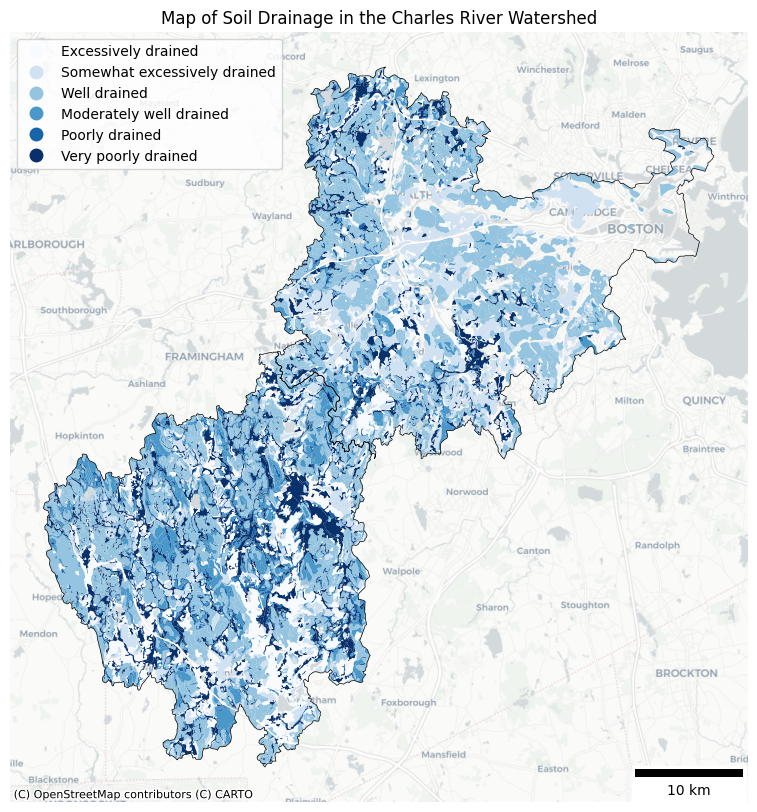

In [110]:
#Soil drainage map
ax=Soils.to_crs(epsg=3857).plot(column='Drain_Code',cmap='Blues',legend=True,legend_kwds={'loc':'upper left'},figsize=(10,10))
leg1 = ax.get_legend()
new_legtxt = ['Excessively drained','Somewhat excessively drained','Well drained','Moderately well drained','Poorly drained',
              'Very poorly drained']

#Fixing legend entries
for ix,eb in enumerate(leg1.get_texts()):
    eb.set_text(new_legtxt[ix])

Charles_gdf.to_crs(epsg=3857).boundary.plot(ax=ax, color='black',linewidth=0.5)
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
plt.title("Map of Soil Drainage in the Charles River Watershed")
ax.add_artist(ScaleBar(1,location='lower right'))
ax.set_axis_off()
plt.savefig("Output Maps/Drainage.png")

# Development Pressure

In [25]:
# https://www.mass.gov/doc/healthy-soils-action-plan-2023/download and New England Landscape Futures data from Harvard forest

<IPython.core.display.HTML object>

In [74]:
scenarios=glob.glob('../../Raw_Data/NELF/*05.tif')
scenarios

<IPython.core.display.HTML object>


[
    '../../Raw_Data/NELF\\cc_05.tif',
    '../../Raw_Data/NELF\\ga_05.tif',
    '../../Raw_Data/NELF\\gg_05.tif',
    '../../Raw_Data/NELF\\rt_05.tif',
    '../../Raw_Data/NELF\\yc_05.tif'
]

In [75]:
CC,trans=mask(rio.open('../../Raw_Data/NELF/cc_05.tif'),Charles_gdf.to_crs(epsg=5070).geometry,crop=True,filled=False)
GA,trans=mask(rio.open('../../Raw_Data/NELF/ga_05.tif'),Charles_gdf.to_crs(epsg=5070).geometry,crop=True,filled=False)
GG,trans=mask(rio.open('../../Raw_Data/NELF/gg_05.tif'),Charles_gdf.to_crs(epsg=5070).geometry,crop=True,filled=False)
RT,trans=mask(rio.open('../../Raw_Data/NELF/rt_05.tif'),Charles_gdf.to_crs(epsg=5070).geometry,crop=True,filled=False)
YC,trans=mask(rio.open('../../Raw_Data/NELF/yc_05.tif'),Charles_gdf.to_crs(epsg=5070).geometry,crop=True,filled=False)

<IPython.core.display.HTML object>

Key for coding in NELF data: 
1: High Density Development
2: Low Density Development
3: Unprotected Forest
4: Conserved Forest
5: Agriculture
6: Other
7: Water

In [76]:
NELF_codes=[1,2,3,4,5,6,7]
NELF_colors=['#730000','#E60000','#ABCD66','#5C8944','#F5F57A','#CCCCCC','#00A9E6']
NELF_cmap = mpl.colors.LinearSegmentedColormap.from_list('NELF', NELF_colors, N=7)

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

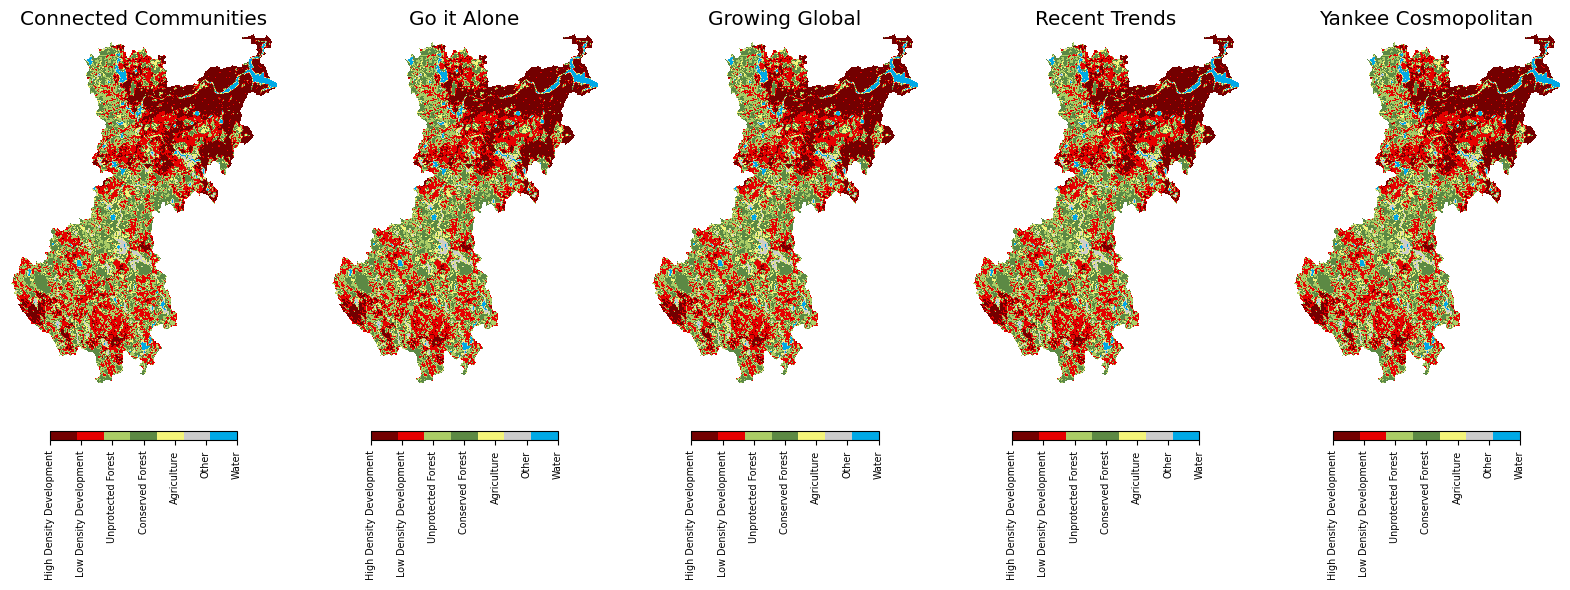

In [77]:
fig, ax=plt.subplots(1,5,figsize=(20,20))
titles=['Connected Communities','Go it Alone','Growing Global','Recent Trends','Yankee Cosmopolitan']
show(CC,ax=ax[0],cmap=NELF_cmap,vmin=1,vmax=7)
show(GA,ax=ax[1],cmap=NELF_cmap,vmin=1,vmax=7)
show(GG,ax=ax[2],cmap=NELF_cmap,vmin=1,vmax=7)
show(RT,ax=ax[3],cmap=NELF_cmap,vmin=1,vmax=7)
show(YC,ax=ax[4],cmap=NELF_cmap,vmin=1,vmax=7)
for i in [0,1,2,3,4]:
    ax[i].set_axis_off()
    cbar=fig.colorbar(ax[i].imshow(CC[0,:,:],cmap=NELF_cmap),ax=ax[i],orientation='horizontal',pad=0.03,shrink=0.7)
    cbar.set_ticks(ticks=[1,2,3,4,5,6,7], labels=['High Density Development','Low Density Development','Unprotected Forest','Conserved Forest',
                                                  'Agriculture','Other','Water'], rotation=90,fontsize='x-small')
    ax[i].set_title(titles[i],fontsize='x-large')
plt.savefig('Output Maps/NELF 2060.png')

<IPython.core.display.HTML object>

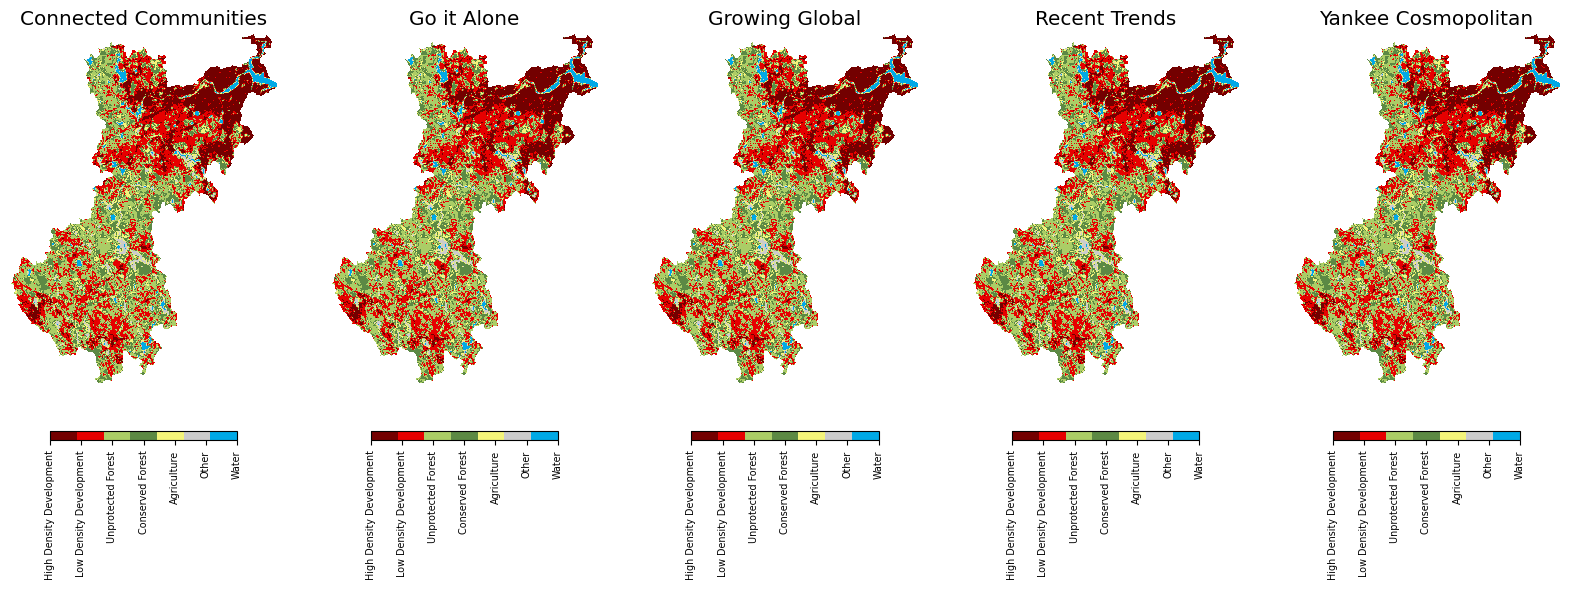

In [78]:
scenarios=glob.glob('../../Raw_Data/NELF/*01.tif')
CC,trans=mask(rio.open('../../Raw_Data/NELF/cc_01.tif'),Charles_gdf.to_crs(epsg=5070).geometry,crop=True,filled=False)
GA,trans=mask(rio.open('../../Raw_Data/NELF/ga_01.tif'),Charles_gdf.to_crs(epsg=5070).geometry,crop=True,filled=False)
GG,trans=mask(rio.open('../../Raw_Data/NELF/gg_01.tif'),Charles_gdf.to_crs(epsg=5070).geometry,crop=True,filled=False)
RT,trans=mask(rio.open('../../Raw_Data/NELF/rt_01.tif'),Charles_gdf.to_crs(epsg=5070).geometry,crop=True,filled=False)
YC,trans=mask(rio.open('../../Raw_Data/NELF/yc_01.tif'),Charles_gdf.to_crs(epsg=5070).geometry,crop=True,filled=False)
fig, ax=plt.subplots(1,5,figsize=(20,20))
titles=['Connected Communities','Go it Alone','Growing Global','Recent Trends','Yankee Cosmopolitan']
show(CC,ax=ax[0],cmap=NELF_cmap,vmin=1,vmax=7)
show(GA,ax=ax[1],cmap=NELF_cmap,vmin=1,vmax=7)
show(GG,ax=ax[2],cmap=NELF_cmap,vmin=1,vmax=7)
show(RT,ax=ax[3],cmap=NELF_cmap,vmin=1,vmax=7)
show(YC,ax=ax[4],cmap=NELF_cmap,vmin=1,vmax=7)
for i in [0,1,2,3,4]:
    ax[i].set_axis_off()
    cbar=fig.colorbar(ax[i].imshow(CC[0,:,:],cmap=NELF_cmap),ax=ax[i],orientation='horizontal',pad=0.03,shrink=0.7)
    cbar.set_ticks(ticks=[1,2,3,4,5,6,7], labels=['High Density Development','Low Density Development','Unprotected Forest','Conserved Forest',
                                                  'Agriculture','Other','Water'], rotation=90,fontsize='x-small')
    ax[i].set_title(titles[i],fontsize='x-large')
plt.savefig('Output Maps/NELF 2020.png')

In [79]:
# Add summary data

<IPython.core.display.HTML object>

# UMASS CAPS Data

<IPython.core.display.HTML object>

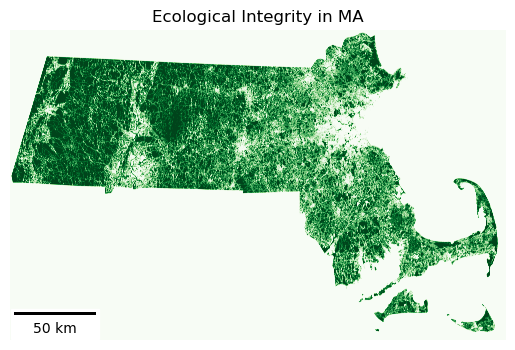

In [26]:
#Open and visualize caps data for whole state
UMASS = rio.open('../../Raw_Data/standard/standard/iei.tif').read(1)
plot_extent = rio.plot.plotting_extent(rio.open('../../Raw_Data/standard/standard/iei.tif'))
f, ax =plt.subplots()

show(UMASS,ax=ax,cmap='Greens',extent=plot_extent)
ax.set_axis_off()
ax.set(title='Ecological Integrity in MA')
ax.add_artist(ScaleBar(1,location='lower left'))

<IPython.core.display.HTML object>

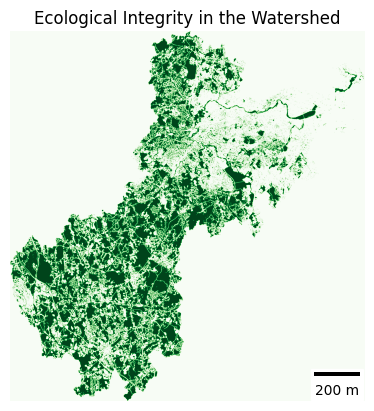

In [71]:
# Just for CRW
UMASS,trans=mask(rio.open('../../Raw_Data/standard/standard/iei.tif'),Charles_gdf.to_crs(epsg=26986).geometry,crop=True)
f, ax =plt.subplots()

show(UMASS,ax=ax,cmap='Greens')
ax.set(title='Ecological Integrity in the Watershed')
ax.add_artist(ScaleBar(1,location='lower right'))
ax.set_axis_off()
plt.savefig('Output Maps/CAPS Ecological Integrity.png')

In [ ]:
fig, (aximg, axhist) = plt.subplots(1, 2, figsize=(14,7))
show(UMASS, ax=aximg,cmap='Greens')
rio.plot.show_hist(UMASS[UMASS>0], bins=10, ax=axhist)
plt.show()

<IPython.core.display.HTML object>

# Impervious Cover

In [30]:
NLCD2019_imp=ee.Image('USGS/NLCD_RELEASES/2019_REL/NLCD/2019').clip(Charles).select('impervious').reproject(crs='EPSG:26986',scale=30)
imp2019=geemap.ee_export_image(
    NLCD2019_imp, filename='../../Working_Data/imp2019.tif', region=Charles.geometry(), file_per_band=False
)

<IPython.core.display.HTML object>

Generating URL ...
Please wait ...
Data downloaded to C:\Users\Chad\Desktop\CRWA Project\Working_Data\imp2019.tif


In [31]:
NLCD2021_imp=ee.Image('USGS/NLCD_RELEASES/2021_REL/NLCD/2021').clip(Charles).select('impervious').reproject(crs='EPSG:26986',scale=30)
imp2021=geemap.ee_export_image(
    NLCD2021_imp, filename='../../Working_Data/imp2021.tif', region=Charles.geometry(), file_per_band=False
)

<IPython.core.display.HTML object>

Generating URL ...
Please wait ...
Data downloaded to C:\Users\Chad\Desktop\CRWA Project\Working_Data\imp2021.tif


<IPython.core.display.HTML object>

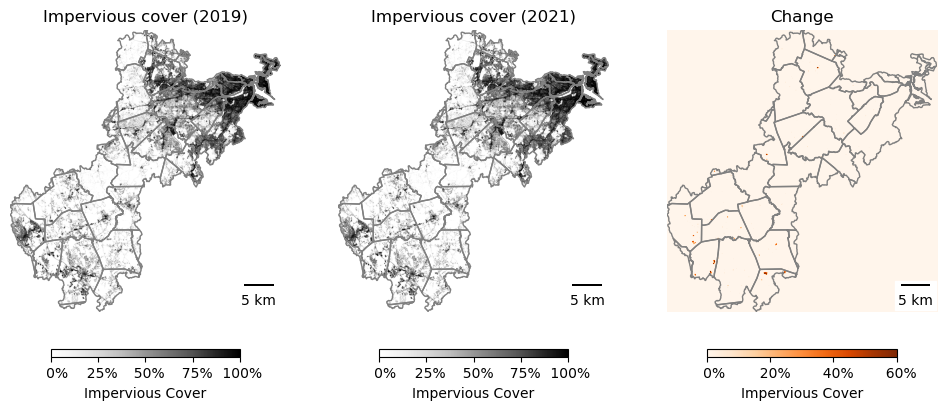

In [32]:
f, ax =plt.subplots(nrows=1, ncols=3,figsize=(10,10))
f.tight_layout()

plot_extent = rio.plot.plotting_extent(rio.open('../../Working_Data/imp2019.tif'))
imp2019,trans=mask(rio.open('../../Working_Data/imp2019.tif'),Charles_gdf.to_crs(epsg=26986).geometry,crop=True)
hidden = ax[0].imshow(imp2019[0,:,:],cmap='Grays',extent=plot_extent)

# Add data and layers
show(imp2019,cmap='Grays',ax=ax[0],extent=plot_extent)
towns.to_crs(epsg=26986).boundary.plot(ax=ax[0], color='gray',linewidth=1)

# Add colorbar using hidden version of raster
f.colorbar(hidden,ax=ax[0],cmap='Grays',orientation='horizontal',aspect=25,shrink=0.7,pad=.04,label='Impervious Cover',format="%4i%%")

# Set properties of plot
ax[0].set(title='Impervious cover (2019)')
ax[0].add_artist(ScaleBar(1,location='lower right'))
ax[0].set_axis_off()


plot_extent = rio.plot.plotting_extent(rio.open('../../Working_Data/imp2021.tif'))
imp2021,trans=mask(rio.open('../../Working_Data/imp2021.tif'),Charles_gdf.to_crs(epsg=26986).geometry,crop=True)
hidden = ax[1].imshow(imp2021[0,:,:],cmap='Grays',extent=plot_extent)

# Add data and layers
show(imp2021,cmap='Grays',ax=ax[1],extent=plot_extent)
towns.to_crs(epsg=26986).boundary.plot(ax=ax[1], color='gray',linewidth=1)

# Add colorbar using hidden version of raster
f.colorbar(hidden,ax=ax[1],cmap='Grays',orientation='horizontal',aspect=25,shrink=0.7,pad=.04,label='Impervious Cover',format="%4i%%")

# Set properties of plot
ax[1].set(title='Impervious cover (2021)')
ax[1].add_artist(ScaleBar(1,location='lower right'))
ax[1].set_axis_off()

hidden = ax[2].imshow(imp2021[0,:,:]-imp2019[0,:,:],cmap='Oranges',extent=plot_extent,vmin=0,vmax=60)

# Add data and layers
show(imp2021-imp2019,cmap='Oranges',ax=ax[2],extent=plot_extent,vmin=0,vmax=60)
towns.to_crs(epsg=26986).boundary.plot(ax=ax[2], color='gray',linewidth=1)

# Add colorbar using hidden version of raster
f.colorbar(hidden,ax=ax[2],cmap='Oranges',orientation='horizontal',aspect=25,shrink=0.7,pad=.04,label='Impervious Cover',format="%4i%%")

# Set properties of plot
ax[2].set(title='Change')
ax[2].add_artist(ScaleBar(1,location='lower right'))
ax[2].set_axis_off()

f.savefig('Impervious Cover 2019 and 2021.png',bbox_inches=mpl.transforms.Bbox.from_bounds(0.3,1,9.7,4.5))

# Tree Committees vs. Wardens

# Land Cover Maps

In [ ]:
# Unzip CRWA files
zipfile.ZipFile(r"C:\Users\Chad\Desktop\CRWA Project\Raw_Data\Send_CR_LandCover_2021.zip").extractall(path="C:/Users/Chad/Desktop/CRWA Project/Raw_Data/Send_CR_LandCover_2021/")
zipfile.ZipFile(r"C:\Users\Chad\Desktop\CRWA Project\Raw_Data\Send_CR_LULC_2021.zip").extractall(path="C:/Users/Chad/Desktop/CRWA Project/Raw_Data/Send_CR_LULC_2021/")

In [34]:
LC2021=rio.open('../../Raw_Data/Send_CR_LandCover_2021/Send_CR_LandCover_2021/landcover_2021_charlesriver_v4a.tif').read(1)
LULC2021=rio.open('../../Raw_Data/Send_CR_LULC_2021/Send_CR_LULC_2021/landuselandcover_2021_charlesriver_v8a.tif').read(1)

<IPython.core.display.HTML object>

MemoryError: Unable to allocate 101. GiB for an array with shape (1, 342425, 317340) and data type uint8

In [ ]:
# Get MASSGIS data and compare to these

In [ ]:
#Forest Areas
NLCD2019lc=ee.Image('USGS/NLCD_RELEASES/2019_REL/NLCD/2019').clip(Charles).select('landcover')

In [ ]:
#Impervious Cover
NLCD2019=ee.Image('USGS/NLCD_RELEASES/2019_REL/NLCD/2019').clip(Charles).select('impervious')
map_2 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
image_viz_params = {
    'bands': ['impervious'],
    'min': 0,
    'max': 100,
    'palette': 'plasma'
}
map_2.add_layer(NLCD2019, image_viz_params)
map_2

#NLCD data from previous years to see changes

# Climate-driven threats to trees

In [ ]:
# Changes in rainfall, flooding, riparian flooding, temperature ee.ImageCollection("NASA/ORNL/DAYMET_V4")
# Insects and pest pressure https://www.fs.usda.gov/foresthealth/applied-sciences/mapping-reporting/national-risk-maps.shtml
# Shifting of weather data to during flowering (graph of temperature, storms over time (smaller time frame) summarized at the watershed)
# Hemlock wooly adelgate, beech leaf disease, emerald ash borer, oak wilt
# How does climate layer on top of the disease stuff

# Dams

In [ ]:
#https://www.mass.gov/info-details/massgis-data-dams

# EJ

In [ ]:
# MASSGIS EJ pop, Census data, Redlining
# Heat hours https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0224959#pone.0224959.ref015 or https://climate-vulnerability.mapc.org/
# NASA Appears LST monthly averages!

# FEMA flood zones

In [ ]:
# https://www.mass.gov/info-details/massgis-data-fema-national-flood-hazard-layer

# AF TES

In [ ]:
# https://www.treeequityscore.org/map#8.58/42.24/-71.4325

# Towns

In [ ]:
#https://www.mass.gov/info-details/massgis-data-municipalities

# Invasive Species Data Collection

In [ ]:
#Extract Sentinel 2 bands and indices of interest
def extractBandsIndices(image):
    return image.select(['B2','B3','B4','B5_10m','B6_10m','B7_10m','B8','B8A_10m','B11_10m','B12_10m',
                         'NDVI','NBR','SAVI','RENDVI','EVI'])

In [ ]:
#Resample Sentinel 2 bands to 10 m
def resample10m(image):
    proj_10m=image.select('B4').projection()
    B5_res=image.select('B5').resample('bicubic').reproject(proj_10m).rename('B5_10m')
    B6_res=image.select('B6').resample('bicubic').reproject(proj_10m).rename('B6_10m')
    B7_res=image.select('B7').resample('bicubic').reproject(proj_10m).rename('B7_10m')
    B8A_res=image.select('B8A').resample('bicubic').reproject(proj_10m).rename('B8A_10m')
    B11_res=image.select('B11').resample('bicubic').reproject(proj_10m).rename('B11_10m')
    B12_res=image.select('B12').resample('bicubic').reproject(proj_10m).rename('B12_10m')
    return image.addBands([B5_res,B6_res,B7_res,B8A_res,B11_res,B12_res])

In [ ]:
#Add 5 vegetation indices of interest
def addIndices(image):
    NDVI = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    NBR = image.normalizedDifference(['B12_10m','B8']).rename('NBR')
    SAVI = image.expression(
        '1.5 * ((NIR - RED)) / (NIR + RED + 0.5)', {
            'NIR' : image.select('B8'),
            'RED' : image.select('B4'),
        }).rename('SAVI')
    RENDVI = image.normalizedDifference(['B6_10m','B5_10m']).rename('RENDVI')
    EVI = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR' : image.select('B8'),
            'RED' : image.select('B4'),
            'BLUE': image.select('B2')}).rename('EVI')
    return image.addBands([NDVI,NBR,SAVI,RENDVI,EVI])

In [ ]:
#Cloud mask function
def mask_s2_clouds(image):
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = (
        qa.bitwiseAnd(cloud_bit_mask)
        .eq(0)
        .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    )
    return image.updateMask(mask).divide(10000)

In [ ]:
#Land cover mask function
def mask_forests(image):
    mask=(NLCD2019lc.eq(41).Or(NLCD2019lc.eq(42).Or(NLCD2019lc.eq(43))))
    return image.updateMask(mask)

In [ ]:
#Pre-processing sentinel-2 data
S2_All=ee.ImageCollection(("COPERNICUS/S2_SR_HARMONIZED")).map(mask_s2_clouds).filterBounds(Charles.geometry()).map(Charclip).map(resample10m).map(addIndices).map(extractBandsIndices)

In [ ]:
S2_All.size()

In [ ]:
S2_All_list=S2_All.toList(S2_All.size())

In [ ]:
#Map of first image in collection
map_3 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
map_3.add_layer(ee.Image(S2_All_list.get(1)).visualize(bands=['B4','B3','B2'],max=0.2))
map_3

In [ ]:
NDVI=S2_All.select('NDVI')

In [ ]:
NDVI_list=NDVI.toList(NDVI.size())

In [ ]:
map_4 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
map_4.add_layer(ee.Image(NDVI_list.get(1)))
map_4

# Scratch workspace

In [ ]:
#Forest Areas
NLCD2019lc=ee.Image('USGS/NLCD_RELEASES/2019_REL/NLCD/2019').clip(Charles).select('landcover')
map_1 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
map_1.add_layer(NLCD2019lc.updateMask(NLCD2019lc.eq(41)),name='Deciduous Forest',color='light green')
map_1.add_layer(NLCD2019lc.updateMask(NLCD2019lc.eq(42)),name='Evergreen Forest',color='dark green')
map_1.add_layer(NLCD2019lc.updateMask(NLCD2019lc.eq(43)),name='Mixed Forest',color='green')
map_1

#NLCD change maps for forest types, check out different times
#Add boundary to map

In [ ]:
# Create HTML map of each year for the forest cover data
for i in range(2000,2021):
    year=i
    image=ee.ImageCollection('MODIS/006/MOD44B').filterDate(str(i)+'-01-01',str(i+1)+'-01-01').map(Charclip)
    image_viz_params = {
        'bands': ['Percent_Tree_Cover'],
        'min': 0,
        'max': 100,
        'palette': 'Greens'
    }
    map_1 = geemapf.Map(center=[42.36565, -71.10832], zoom=9,tiles="cartodb positron")
    map_1.add_layer(image, image_viz_params)
    legend_keys=['0%','25%','50%','75%','100%']
    map_1.add_legend('Percent_Tree_Cover',legend_keys,["#f7fcf5","#c7e9c0","#74c476","#238b45","#00441b"])
    map_1
    map_1.save('TreeCoverMaps\Tree Cover '+str(i)+'.html')



In [ ]:
#Extracting Charles River Watershed Boundary
CRW_ = gpd.read_file("..\Raw_Data\watshd\watshdp1.shp")
CRW = CRW_[CRW_.NAME=="CHARLES"]
CRW.plot()

In [ ]:
#List of invasive species of interest
# Japanese knotweed, Asian bittersweet, glossy buckthorn, euonymous, multiflora rose, cork tree, kudzu, porcelain berry
# https://www.massaudubon.org/nature-wildlife/invasive-plants-in-massachusetts
def get_obs(years,taxon_id):
  response=pyinaturalist.v1.observations.get_observations(year=years,taxon_id=taxon_id,geo=True,page='all',place_id=2)
  my_observations = pyinaturalist.Observation.from_json_list(response)
  df = pd.DataFrame(
      [
          {
              'latitude': o.location[0],
              'longitude': o.location[1],
              'date': o.observed_on.isoformat()
          }
          for o in my_observations
          if o.location
      ]
  )
  gdf = gpd.GeoDataFrame(
      df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
  )
  return gdf

In [ ]:
# https://nbviewer.org/gist/perrygeo/c426355e40037c452434
def density_heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.gaussian_filter(logheatmap, smoothing, mode='nearest')

    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:

years=[2020,2021,2022,2023,2024]
knotweed=914922
bittersweet=64540
buckthorn=55972
euonymus=117433
multiflora=78882
corktree=166636
porcelain=204237
kudzu=62671
barberry=58727

knot_gdf=get_obs(years,knotweed)
bitt_gdf=get_obs(years,bittersweet)
buck_gdf=get_obs(years,buckthorn)
euon_gdf=get_obs(years,euonymus)
mult_gdf=get_obs(years,multiflora)
cork_gdf=get_obs(years,corktree)
porc_gdf=get_obs(years,porcelain)
kudz_gdf=get_obs(years,kudzu)
barb_gdf=get_obs(years,barberry)

In [ ]:
d={
  'Knotweed':knot_gdf,
  'Bittersweet':bitt_gdf,
  'Buckthorn':buck_gdf,
  'Euonymus':euon_gdf,
  'Multiflora':mult_gdf,
  'Corktree':cork_gdf,
  'Porcelain Berry':porc_gdf,
  'Kudzu':kudz_gdf,
  'Barberry':barb_gdf
}
for name, value in d.items():
  ax = Charles_lower_gdf.to_crs(epsg=3857).boundary.plot(figsize=(10,10), color='blue',linewidth=0.5)
  Charles_upper_gdf.to_crs(epsg=3857).boundary.plot(ax=ax,figsize=(10,10), color='green',linewidth=0.5)
  value.clip(Charles_gdf).to_crs(epsg=3857).plot(ax=ax)
  plt.title(name+" (2020 - 2024)")
  cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
  ax.set_axis_off()
  ax.add_artist(ScaleBar(1,location='lower right'))
  plt.savefig(name+'.png')

In [ ]:
#Create function to clip image to be used for clipping image collections
def Charclip(image):
    return image.clip(Charles)

In [ ]:
#Import and clip MODIS VCF data to Charles and animate
treeData=ee.ImageCollection('MODIS/006/MOD44B').filterBounds(Charles.geometry()).select('Percent_Tree_Cover').map(Charclip)
videoArgs = {
  'dimensions': 768,
  'region': Charles.geometry(),
  'framesPerSecond': 1,
  'crs': 'EPSG:3857',
  'min': 0,
  'max': 100,
  'palette': ["#f7fcf5","#c7e9c0","#74c476","#238b45","#00441b"],
  'format':'gif'
}

In [ ]:
#Obtain link to animation
urllib.request.urlretrieve(treeData.getVideoThumbURL(videoArgs),'../../Working_Data/treeCoverNoLabels.gif')
geemap.add_text_to_gif('../../Working_Data/treeCoverNoLabels.gif','treeCover.gif',text_sequence=[2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020],font_color='white')

In [ ]:
# Projected climate impacts
# USDA hardiness zones maps
# Rainfall, drought prediction
# Temperature projections

In [ ]:
#Priority planting recommendations as areas with low canopy that already have permeable areas

In [ ]:
# American Forests tree equity score analyzer
# Message Mushtaaq about why there are gaps in the data

In [ ]:
# South Natick Dam
# Watertown Dam (probably not happening soon)
# https://maps.coastalresilience.org/massachusetts/